# This Notebook will introduce MCMC comparing with central limit theorem.

In [2]:
import os
import random
import os.path
import hashlib
import errno

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import factorial
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Normal, Poisson,Bernoulli,Uniform
import torch.autograd as autograd


In [3]:
def contourf(mean,cov,plot_lim,num=100):
    x = np.linspace(-plot_lim, plot_lim, num)
    y = np.linspace(-plot_lim, plot_lim, num)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    return X,Y,Z

In [4]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark=True    
set_seed(42)

# Central limit therom
## If the data is sampled by the iid, data distribution convergence the Gaussian distribution. 
+ The mean of the sampling distribution is the mean of the popultaion
## $\mu_{\bar x} = \mu$  
## $\sigma_{\bar x} = \frac{\sigma}{\sqrt n}$  
## $\bar X \sim N(\mu, \frac{\sigma}{\sqrt n})$ 
where n : sample size 

--------

# Poisson Distribution

PMF
\begin{align}
P(X=k) = \frac{\lambda^k e^{-\lambda}}{k!}\\
\mu : \lambda\\
Var : \lambda
\end{align}


# Bernoulli Distribution 
PMF
\begin{align}
P(X=1) &= p\\
P(X=0) &= 1-p\\
\mu : p\\
Var : p(1-p)\\
\end{align}

# Uniform Distribution 
(only Uniform distribution have PDF among 3 distribution)
PDF
\begin{align}
P(X\in [a,b]) &= \frac{1}{b-a}\\
P(X\not\in [a,b]) &= 0\\
\mu : (a+b)/2\\
Var : \frac{(b-a)^2}{12}\\
\end{align}

In [5]:
# Implementation each distribution using class and module  
class my_Poisson(object):
    def __init__(self, lamb):
        self.lamb = lamb
    def sampling(self,k):
        assert (k>=0).all(), "k must be positive "
        return (self.lamb**k )*(np.exp(-self.lamb))  /factorial(k)

class my_Uniform(object):
    def __init__(self,low=0,high =1):
        self.low = low
        self.high = high
    
    def sampling(self,n):
        return (self.high-self.low)*np.random.rand(n)


class my_Bernoulli(object):
    def __init__(self,p = 0.5):
        self.p = p
    def sampling(self,n):
        return  (np.random.rand(n)>=0.5).astype(np.uint8)

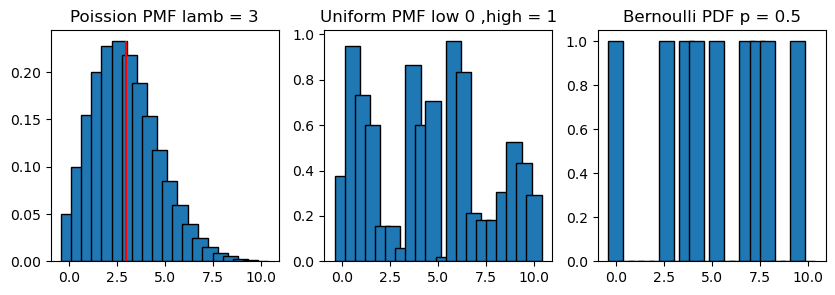

In [6]:
lamb =3
data_num = 20
my_p = my_Poisson(lamb)

x_value = np.linspace(0,10,data_num)
poisson_data = my_p.sampling(x_value)
#####
my_u = my_Uniform()
uniform_data = my_u.sampling(data_num)

#####
my_b = my_Bernoulli()
bernoulli_data = my_b.sampling(data_num)

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.title(f"Poission PMF lamb = {lamb}")
plt.bar(x_value, poisson_data,edgecolor ='black')
plt.vlines(lamb, 0.0, np.max(poisson_data),colors='red')
plt.subplot(132)
plt.bar(x_value, uniform_data,edgecolor ='black')
plt.title(f"Uniform PMF low 0 ,high = {1}")
plt.subplot(133)
plt.bar(x_value, bernoulli_data,edgecolor ='black')
plt.title(f"Bernoulli PDF p = {0.5}")
plt.show()

# Using Pytorch Package and Central Limit Thorem

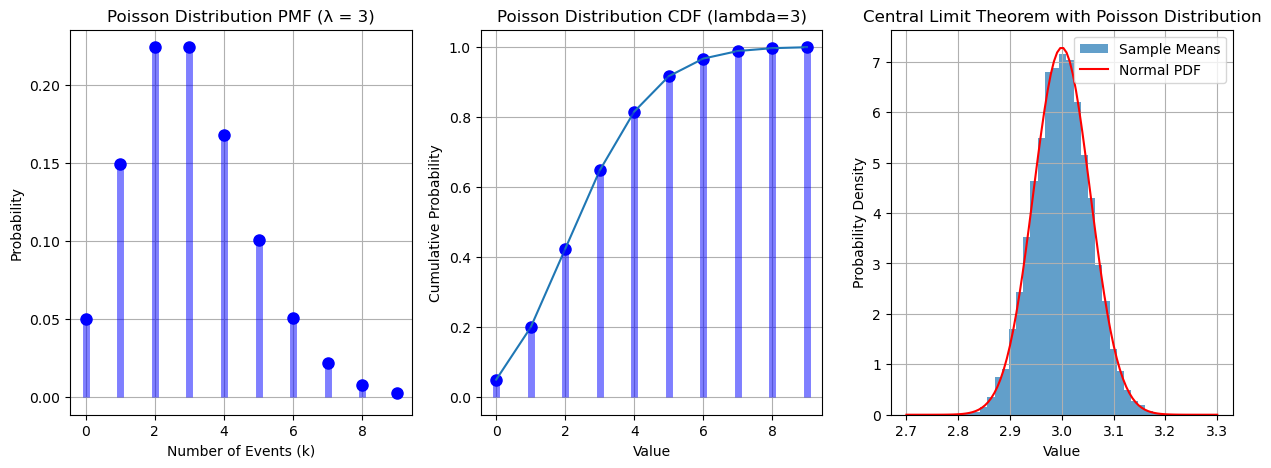

In [7]:
arange = 10      # sampling num corresponding PMF 
n_samples = 1000 # 
n_experiments = 10000 # It's need becuase of means sample

lam = 3
# Create a Poisson distribution
poisson = Poisson(lam)
# Create an array of integers from 0 to 20 for the x-axis (number of events)
plt.figure(figsize=(15,5))

# if we test PMF, as you know PMF is a discreate function, so only integer is allowed. But sampling allows floating point. 
# k_sample= torch.arange(0, arange)
poisson.sample([n_samples])
k_sample = torch.arange(0,arange)
pmf_values_poisson = poisson.log_prob(k_sample).exp()
##
experiments_poisson = poisson.sample([n_experiments, n_samples])
means_poisson = experiments_poisson.mean(dim=1)
predicted_dist_poisson = Normal(3, np.sqrt(3/n_samples))
x_values_poisson = torch.linspace(lamb-0.3, lamb+0.3, 100)
pdf_values_poisson = torch.exp(predicted_dist_poisson.log_prob(x_values_poisson))

plt.subplot(131)
# plt.hist(pmf_values)
plt.plot(k_sample, pmf_values_poisson, 'bo', ms=8)
plt.vlines(k_sample, 0, pmf_values_poisson, colors='b', lw=5, alpha=0.5)
plt.title(f'Poisson Distribution PMF (λ = {lam})')
plt.xlabel('Number of Events (k)')
plt.ylabel('Probability')
plt.grid(True)

# cdf_line_poisson = torch.cumsum(poisson.log_prob(k_sample).exp(),dim=0)

cdf_values_poisson = torch.cumsum(pmf_values_poisson, dim=0)

plt.subplot(132)
plt.plot(k_sample, cdf_values_poisson.numpy(), 'bo', ms=8)
plt.plot(k_sample.numpy(), cdf_values_poisson.numpy(),  ms=8)
plt.vlines(k_sample, 0, cdf_values_poisson, colors='b', lw=5, alpha=0.5)
plt.title('Poisson Distribution CDF (lambda=3)')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.grid(True)

plt.subplot(133)

plt.hist(means_poisson, bins=30, density=True, alpha=0.7, label='Sample Means')
plt.plot(x_values_poisson.numpy(), pdf_values_poisson.numpy(), 'r-', label='Normal PDF')
plt.title('Central Limit Theorem with Poisson Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)


plt.show()

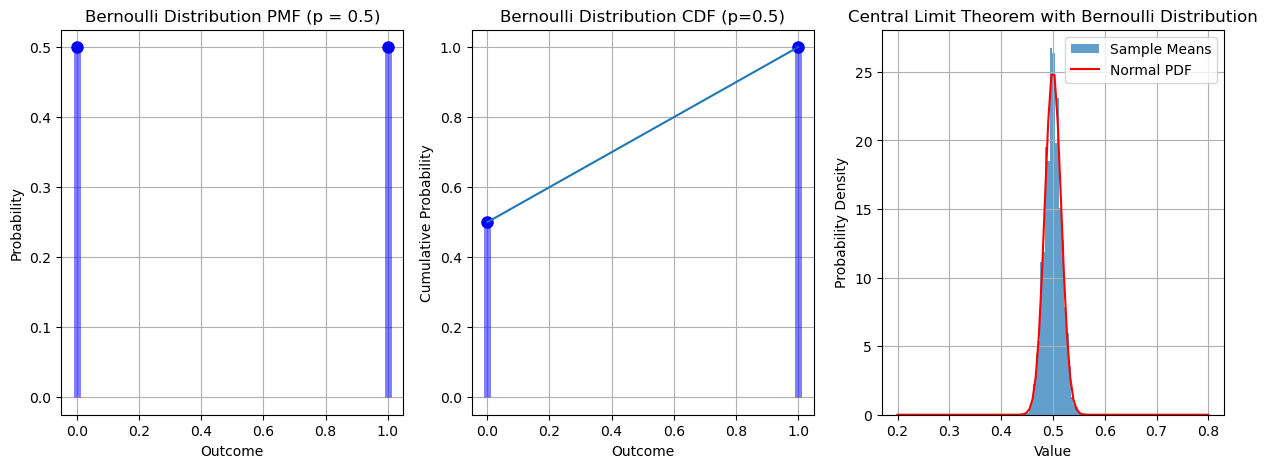

In [8]:
from torch.distributions import Normal

arange = 10    
n_samples = 1000
n_experiments = 10000 

p = 0.5
# Create a Bernoulli distribution
bernoulli = Bernoulli(p)

# Create an array of integers from 0 to 2 for the x-axis (number of events)
plt.figure(figsize=(15,5))

# For Bernoulli distribution, there are only two possible outcomes: 0 and 1
k_sample = torch.tensor([0.0, 1.0])
pmf_values_bernoulli = torch.exp(bernoulli.log_prob(k_sample))

# Perform the experiments
experiments_bernoulli = bernoulli.sample([n_experiments, n_samples])

# Compute the means of the experiments
means_bernoulli = experiments_bernoulli.mean(dim=1)

# Compute the PDF of the Normal distribution that the Central Limit Theorem predicts
# For a Bernoulli distribution, the mean is p and the variance is p*(1-p)
predicted_dist_bernoulli = Normal(p, np.sqrt((p*(1-p))/n_samples))
x_values_bernoulli = torch.linspace(p-0.3, p+0.3, 100)
pdf_values_bernoulli = torch.exp(predicted_dist_bernoulli.log_prob(x_values_bernoulli))

plt.subplot(131)
# Plot the PMF
plt.plot(k_sample, pmf_values_bernoulli, 'bo', ms=8)
plt.vlines(k_sample, 0, pmf_values_bernoulli, colors='b', lw=5, alpha=0.5)
plt.title(f'Bernoulli Distribution PMF (p = {p})')
plt.xlabel('Outcome')
plt.ylabel('Probability')
plt.grid(True)

# Compute the CDF using torch.cumsum function
cdf_values_bernoulli = torch.cumsum(pmf_values_bernoulli, dim=0)

plt.subplot(132)
# Plot the CDF
plt.plot(k_sample, cdf_values_bernoulli.numpy(), 'bo', ms=8)
plt.plot(k_sample, cdf_values_bernoulli.numpy(),  ms=8)
plt.vlines(k_sample, 0, cdf_values_bernoulli, colors='b', lw=5, alpha=0.5)
plt.title('Bernoulli Distribution CDF (p=0.5)')
plt.xlabel('Outcome')
plt.ylabel('Cumulative Probability')
plt.grid(True)

plt.subplot(133)
# Plot the histogram of the means
plt.hist(means_bernoulli.numpy(), bins=30, density=True, alpha=0.7, label='Sample Means')
# Plot the PDF of the predicted Normal distribution
plt.plot(x_values_bernoulli.numpy(), pdf_values_bernoulli.numpy(), 'r-', label='Normal PDF')
plt.title('Central Limit Theorem with Bernoulli Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

plt.show()


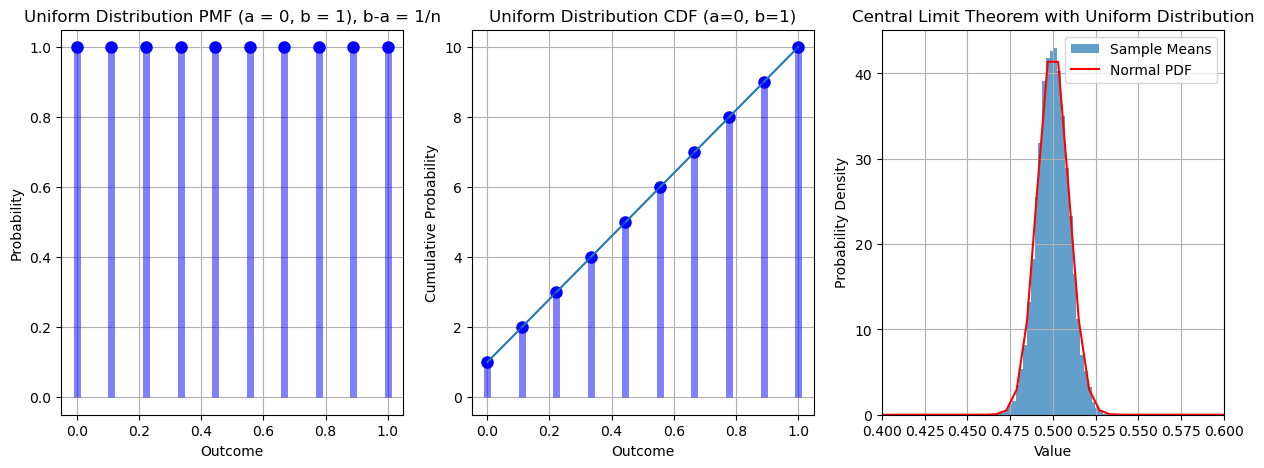

In [9]:
# Define the parameters for the uniform distribution
a = 0
b = 1

# Create a Uniform distribution
uniform = Uniform(a, b)
# Create an array of floats from 0 to 1 for the x-axis (possible outcomes)
plt.figure(figsize=(15,5))
# For Uniform distribution, all outcomes are equally likely
x_values_uniform = torch.linspace(a, b, arange)
pmf_values_uniform = torch.ones(arange) / (b - a)  # pmf is 1/(b-a) for a uniform distribution

# Perform the experiments
experiments_uniform = uniform.sample([n_experiments, n_samples])

# Compute the means of the experiments
means_uniform = experiments_uniform.mean(dim=1)

# Compute the PDF of the Normal distribution that the Central Limit Theorem predicts
# For a Uniform distribution, the mean is (a+b)/2 and the variance is (b-a)^2/12
predicted_dist_uniform = Normal((a+b)/2, np.sqrt(((b-a)**2/12)/n_samples))
x_values_uniform_pdf = torch.linspace((a+b)/2 - 0.3, (a+b)/2 + 0.3, 100)
pdf_values_uniform = torch.exp(predicted_dist_uniform.log_prob(x_values_uniform_pdf))

plt.subplot(131)
# Plot the PMF
plt.plot(x_values_uniform, pmf_values_uniform, 'bo', ms=8)
plt.vlines(x_values_uniform, 0, pmf_values_uniform, colors='b', lw=5, alpha=0.5)
plt.title(f'Uniform Distribution PMF (a = {a}, b = {b}), b-a = 1/n')
plt.xlabel('Outcome')
plt.ylabel('Probability')
plt.grid(True)

# Compute the CDF using torch.cumsum function
cdf_values_uniform = torch.cumsum(pmf_values_uniform, dim=0)

plt.subplot(132)
# Plot the CDF
plt.plot(x_values_uniform, cdf_values_uniform.numpy(), 'bo', ms=8)
plt.plot(x_values_uniform, cdf_values_uniform.numpy(), ms=8)
plt.vlines(x_values_uniform, 0, cdf_values_uniform, colors='b', lw=5, alpha=0.5)
plt.title('Uniform Distribution CDF (a=0, b=1)')
plt.xlabel('Outcome')
plt.ylabel('Cumulative Probability')
plt.grid(True)

plt.subplot(133)
# Plot the histogram of the means
plt.xlim([0.4,0.6])
plt.hist(means_uniform.numpy(), bins=30, density=True, alpha=0.7, label='Sample Means')
# Plot the PDF of the predicted Normal distribution
plt.plot(x_values_uniform_pdf.numpy(), pdf_values_uniform.numpy(), 'r-', label='Normal PDF')
plt.title('Central Limit Theorem with Uniform Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

plt.show()


In [10]:
help(bernoulli.entropy)

Help on method entropy in module torch.distributions.bernoulli:

entropy() method of torch.distributions.bernoulli.Bernoulli instance
    Method to compute the entropy using Bregman divergence of the log normalizer.



# Sampling with ICDF  
In this page, we learns about the sampling means with mathmatical sampling

In [11]:
# import matplotlib
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
# matplotlib.rc('text', usetex=True)
# plt.ylabel('$p(v|s)$')
# plt.title(f"Density of observing $V$ given $S$, $\sigma={eps_std}$")

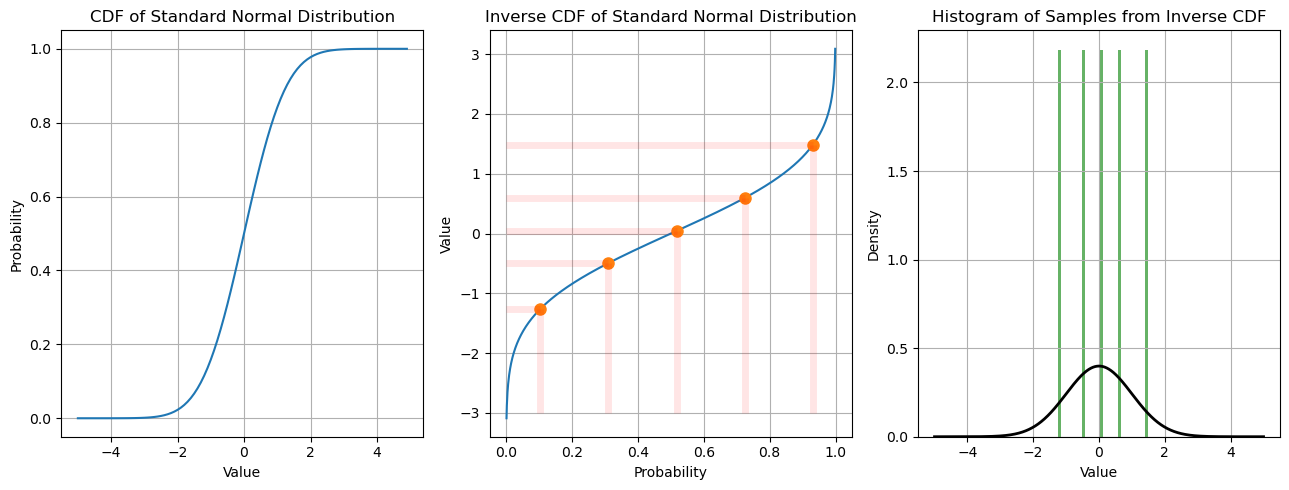

In [17]:
import torch.distributions as dist

# Define a standard normal distribution
N = Normal(0, 1)

# Compute the inverse CDF
x = torch.linspace(0, 1, 1000)
inverse_cdf = N.icdf(x)
noraml_cdf = N.cdf(torch.arange(-5,5,0.1))

# discreate_x_value = torch.linspace(0,1,50) # change this sample
discreate_x_value = torch.linspace(-3,3,30)

discreate_icdf = N.icdf(discreate_x_value)

# Generate samples from the inverse CDF
samples = N.icdf(torch.rand(100))

# Plot the inverse CDF and the histogram of the samples
fig, axs = plt.subplots(1,3, figsize=(13, 5))

axs[0].plot(torch.arange(-5,5,0.1), noraml_cdf)
axs[0].set_title('CDF of Standard Normal Distribution')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Probability')
axs[0].grid(True)
#####
axs[1].plot(x, inverse_cdf)
axs[1].set_title('Inverse CDF of Standard Normal Distribution')
axs[1].plot(discreate_x_value,discreate_icdf,'o', ms=8) # ms: marker size
axs[1].hlines(discreate_icdf,0,discreate_x_value , colors='red', lw=5, alpha=0.1) #lw: line width
axs[1].vlines(discreate_x_value, -3, discreate_icdf, colors='red', lw=5, alpha=0.1)
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Value')
axs[1].grid(True)
#####
# axs[2].hist(samples.numpy(), bins=30, density=True, alpha=0.6, color="g")
axs[2].hist(torch.clip(discreate_icdf,-4,4), bins=30,density=True, alpha=0.6, color="g")

axs[2].plot(torch.linspace(-5,5,1000),N.log_prob(torch.linspace(-5,5,1000)).exp(),'k', linewidth=2)
axs[2].set_title('Histogram of Samples from Inverse CDF')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Density')
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Rejection Sampling 
Mathmatically, Sampling is value of inverse function, when input the probability.   
Sampling: 주어진 확률 분포의 확률 밀도에 맞게, 관찰값을 생성하는 것   
sampling을 수행한 다는 것은 CDF의 역함수 연산을 수행하는 것과 같다.   
sampling이 어려운 이유는 cdf의 역함수를 계산 하는 것.   
cdf를 구할 수 있어도, inverse cdf를 구하기 어려움.   
수치적으로 정확하게 sampling을 실행하는 것은 어려움이 있음  -> PDF에서 샘플을 추출할 수 있는 여러 접근법 : Rejection Sampling

https://angeloyeo.github.io/2020/09/16/rejection_sampling.html

Step: 
1. 쉽게 샘플링할 수 있는 보조 확률 분포 $g(x)$를 선택. $g(x)$는 원래의 확률 분포 $f(x)$를 모두 포함하게끔 해야함. (함수의 최댓값, 최솟값을 알아야함)
($g(x)$로 Uniform을 사용하는 것이 편하다)
2. $g(x)$에 상수배 $M$을 하여 $f(x)$를 포함하게끔 진행 
3. sampling을 진행하고, 

Pseudo code: 

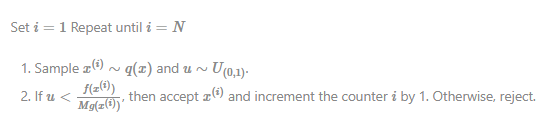

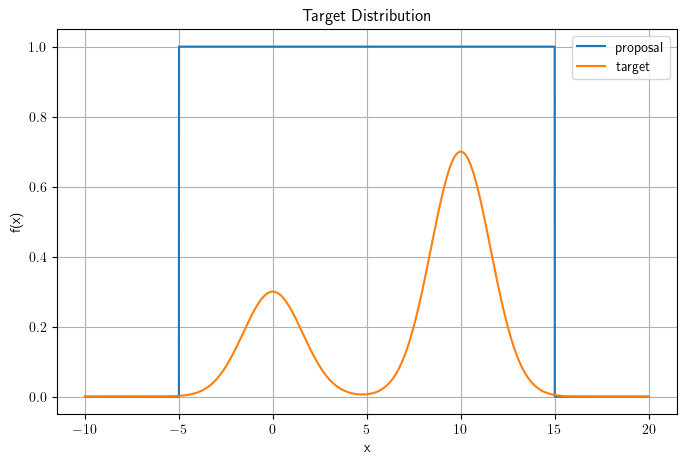

In [447]:

# Define the target distribution
fx  = lambda x:  0.3*torch.exp(-0.2*x**2) + 0.7*torch.exp(-0.2*(x-10)**2)
x = torch.linspace(-10, 20, 1000)
y = fx(x)
x_large = torch.linspace(-10, 20, 10000)
y_large = fx(x_large)
max_y = torch.max(y_large).item() # 가장 높은 값의 value를 selection 
gx = [1 if i>=-5 and i<15 else 0 for i in x_large]





plt.figure(figsize=(8, 5))
plt.plot(x_large,gx, label ='proposal')

plt.plot(x, y,label ='target')
plt.title('Target Distribution')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)

  0%|          | 0/100000 [00:00<?, ?it/s]

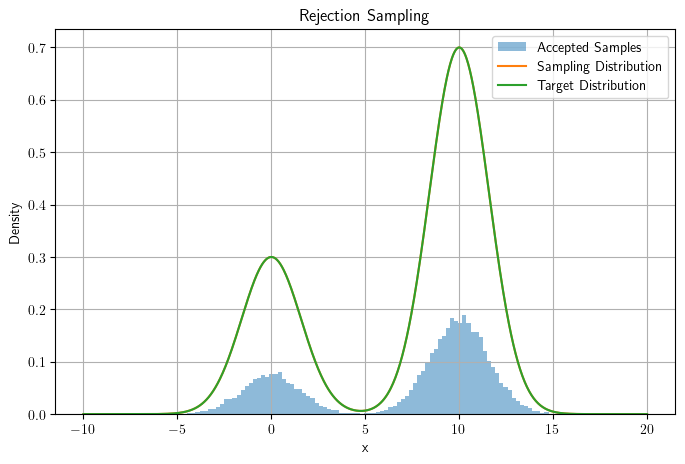

In [449]:
x_large = torch.linspace(-10, 20, 10000)
y_large = fx(x_large)
max_y = torch.max(y_large).item() # 가장 높은 값의 value를 selection 
proposal_distribution = Uniform(-10, 20)  # x 좌표에 대한 sampling
height_distribution =   Uniform(0, max_y) # y_ 좌표에 대한 sampling 
samples = []
for _ in tqdm(range(100000)):
    proposal_sample = proposal_distribution.sample().item() # random하게 x를 뽑은 다음, 
    target_value = fx(torch.tensor(proposal_sample)).item() # target distribution을 추출한다. 
    height_sample = height_distribution.sample().item()     # 
    if height_sample < target_value: # target으로
        samples.append(proposal_sample)
samples = torch.tensor(samples)
# Plot the histogram of the accepted samples, along with the target distribution
plt.figure(figsize=(8, 5))
plt.hist(samples, bins=100, density=True, alpha=0.5, label='Accepted Samples')
plt.plot(x, y, label='Sampling Distribution')

plt.plot(x, y, label='Target Distribution')
plt.title('Rejection Sampling')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


# Marcov Chain

Problem Setting
S: sunny 
C: cloudy
R: rainy

$p(x_n|x_{n-1}) = p(x_n|x_{n-1},x_{n-2},\cdots,x_{1})$
\begin{align}
P =  
\begin{bmatrix}
P(S|S)&P(C|S)&P(R|S)\\
P(S|C)&P(C|C)&P(R|C)\\
P(S|R)&P(C|R)&P(R|R)\\
\end{bmatrix}
\end{align}

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the states
states = ["Sunny", "Cloudy", "Rainy"]

# Define the transition probabilities
transition_matrix = np.array([
    [0.7, 0.2, 0.1],  # P(S|S), P(C|S), P(R|S)
    [0.3, 0.4, 0.3],  # P(S|C), P(C|C), P(R|C)
    [0.2, 0.3, 0.5],  # P(S|R), P(C|R), P(R|R)
])

# Check that the transition probabilities are valid
assert np.allclose(transition_matrix.sum(axis=1), 1), "Rows of the transition matrix should sum to 1."

  0%|          | 0/100000 [00:00<?, ?it/s]

Sunny-> Sunny-> Rainy-> Cloudy-> Sunny-> Cloudy-> Rainy-> Cloudy-> Sunny-> Sunny-> 

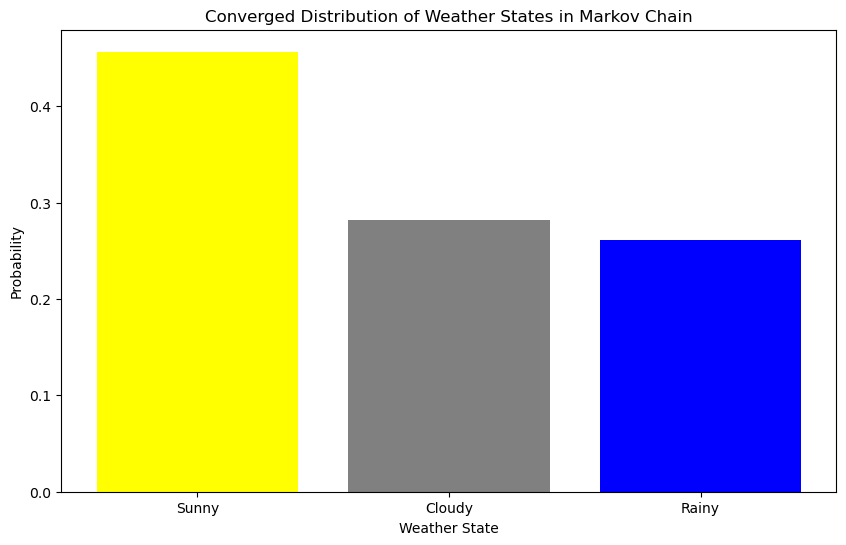

In [35]:
# Define a function to simulate the Markov chain
def simulate_markov_chain(transition_matrix, start_state, num_steps)-> np.array:
    num_states = transition_matrix.shape[0] # 
    current_state = start_state # initialize start state 
    sequence = [current_state]
    for _ in tqdm(range(num_steps),leave = False):
        current_state = np.random.choice(
            np.arange(num_states),             # shape of transition matrix 
            p=transition_matrix[current_state] # setting probability of choice
        )
        sequence.append(current_state)
    return np.array(sequence)

# Define a function to compute the empirical distribution
def empirical_distribution(sequence, num_states):
    counts = np.bincount(sequence, minlength=num_states)
    return counts / counts.sum()

# Run the simulation for a large number of steps and compute the empirical distribution
start_state = 0  # Start in the "Sunny" state
num_steps = 100000
sequence = simulate_markov_chain(transition_matrix, start_state, num_steps)
empirical_dist = empirical_distribution(sequence, len(states))
for i in range(10):
    print(f"{states[sequence[i]]}", end = '-> ')

plt.figure(figsize=(10, 6))
plt.bar(states, empirical_dist, color=['yellow', 'gray', 'blue'])
plt.xlabel("Weather State")
plt.ylabel("Probability")
plt.title("Converged Distribution of Weather States in Markov Chain")
plt.show()

Why doesn't the distribution of Marcov chains follow the Gaussian distribution by the principle of central limmit theorem?  
That's because that the transition state is generally not independent. Let's remark the Central Limite Theorem. CLT have a constrains that Sample follows i.i.d. But, as you know markov chain probability is a conditional probability of previous probability. 

That's because why Marcov chain distribution doesn't convergence the Gaussian distribution by many sampling. 

# MCMC (Monte Carlo Marcov chain)
## Metropolis-Hastings 

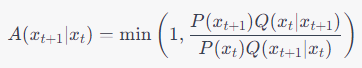
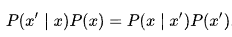
### where $Q(x)$ : Proposal distribution

# $\frac{p(x_{new})}{p(x_{old})}>1$  
if new is good, will be selected , if old is good, reject
$q(x_t|x_{t+1})$ : old proposal  
$q(x_{t+1}|x_t)$ : new proposal


알고리즘에서 생성된 샘플 sequence가 marcov 속성을 가지기 때문 
새로운 sample은 $q(x_{t+1}|x_t)$ : new proposal를 통해서 생성되며, 수락은 그저, 기존것과 현재것을 비교하는 것이기에, 
새로운 sample을 생성하는 것 자체는 현재 시점에 종속된다. 

In [547]:
current_state = 0

proposed_state = proposal_distribution(current_state, 1).sample().item() #N(0,1)
proposed_state #가우시안으로 random sampling

-1.8821033239364624

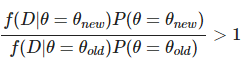
https://angeloyeo.github.io/2020/09/17/MCMC.html

In [548]:
print(fx(torch.tensor(proposed_state)).item())
print(fx(torch.tensor(current_state)).item())
print(fx(torch.tensor(proposed_state)).item() / fx(torch.tensor(current_state)).item())

0.14772020280361176
0.30000001192092896
0.49240065644579506


In [549]:
accept_prob = min(1, fx(torch.tensor(proposed_state)).item() / fx(torch.tensor(current_state)).item())
accept_prob # 대부분의 경우 1보다 작은 값이 return 됨. 그러면, sampling은 언제나 current_state를 위주로 하게 될 것임  

0.49240065644579506

In [524]:
u = torch.rand(1).item() #0 ~1
u

0.8892289400100708

In [525]:
#  이를 방지하고자. Uniform에서 sampling을 하여, 작은 값이더라도 다시 한번 검증을 하는 단계
# recap previous step
if u < accept_prob:
    current_state = proposed_state
current_state

0.3730688691139221

  0%|          | 0/100000 [00:00<?, ?it/s]

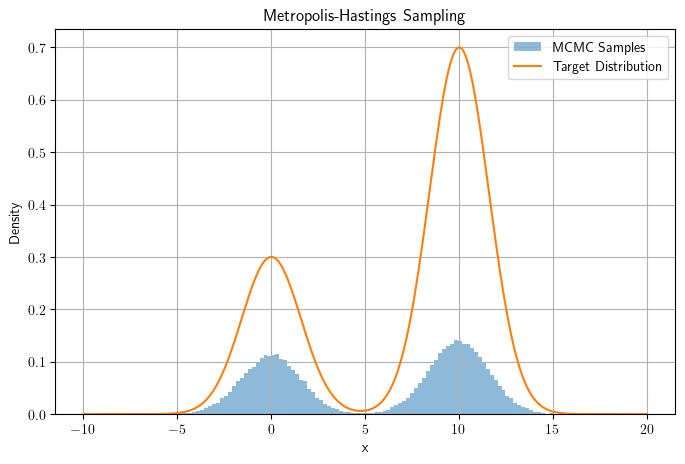

In [467]:
# 제안 분포를 가우시안으로 설정 
#proposal distribution은 symmetric해야함
def proposal_distribution(current_state, scale=1.0):
    return torch.distributions.Normal(current_state, scale)

# Define a function to perform the Metropolis-Hastings algorithm
def metropolis_hastings(fx, proposal_distribution, initial_state, num_samples, scale=1.0):
    current_state = initial_state
    samples = []
    for _ in tqdm(range(num_samples),leave = False):
        proposed_state = proposal_distribution(current_state, scale).sample().item()# N(0,1)
        # proposed_state는 결국 분포가 원래의 분포에 맞게끔 이동하는 과정이라고 이해하면 된다. 
        accept_prob = min(1, fx(torch.tensor(new)).item() / fx(torch.tensor(old)).item())
        # 새로운 propose state가 기존보다 좋다면, accept_prob은 1보다 커지고, 아니라면 1이 될것 
        u = torch.rand(1).item() #0~1 
        # If the random number is less than the acceptance probability, accept the proposed state
        if u < accept_prob:
            current_state = proposed_state

        # Append the current state to the list of samples
        samples.append(current_state)

    # Convert the list of samples to a tensor for easier manipulation
    samples = torch.tensor(samples)

    return samples

# Perform the Metropolis-Hastings algorithm
samples_mh = metropolis_hastings(fx, proposal_distribution, initial_state=0.0, num_samples=100000, scale=1.0)

# Plot the histogram of the samples, along with the target distribution
plt.figure(figsize=(8, 5))
plt.hist(samples_mh, bins=100, density=True, alpha=0.5, label='MCMC Samples')
plt.plot(x, y, label='Target Distribution')
plt.title('Metropolis-Hastings Sampling')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


1.0


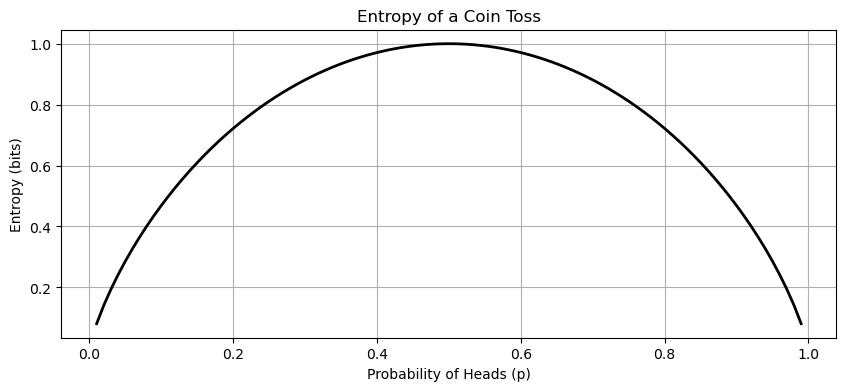

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define the entropy function for a Bernoulli distribution
def entropy(p):  # In this case, Binary cross entropy. 
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

# Define the range of probabilities
p = np.linspace(0.01, 0.99, 100)

# Calculate the entropy for each probability
H = entropy(p)
print(entropy(0.5))
# Plot the entropy
plt.figure(figsize=(10, 4))
plt.plot(p, H, 'k', linewidth=2)
plt.xlabel('Probability of Heads (p)')
plt.ylabel('Entropy (bits)')
plt.title('Entropy of a Coin Toss')
plt.grid(True)
plt.show()


\begin{align}
P(X=0;Dog) &= \frac{1}{10} \\
P(X=1;Cat) &= \frac{5}{10} \\
P(X=2;Human) &= \frac{4}{10}\\
\end{align}

In [366]:
one_hot = torch.eye(3).float()
target = torch.tensor([0,1,2])
one_hot , target

(tensor([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]),
 tensor([0, 1, 2]))

In [269]:
data = torch.randn(3,1,28,28) # N ,C ,H , W
data = data.view(-1,28*28)
data.shape

torch.Size([3, 784])

In [270]:
model =nn.Sequential(*[
    nn.Linear(1*28*28,3),
    nn.Softmax(dim=1)
])

In [271]:
with torch.no_grad():
    output = model(data)
    print(torch.sum(nn.Softmax(dim=1)(output),dim=1))
# total probability 

tensor([1.0000, 1.0000, 1.0000])


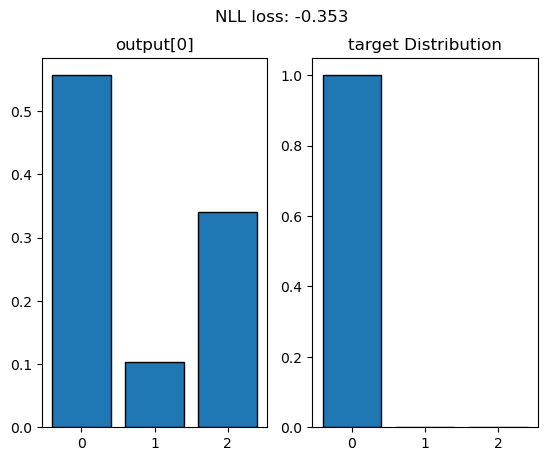

In [375]:
plt.suptitle(f"NLL loss: {np.round(F.nll_loss(output, target).item(),3)}")
plt.subplot(121)
plt.bar(torch.arange(0,3),output[0],edgecolor= 'black')
plt.title("output[0]")
plt.subplot(122)
plt.title("target Distribution")
plt.bar(torch.arange(0,3),one_hot[0],edgecolor= 'black')
plt.show()

# Cross Entropy
\begin{align}
CE &= -\sum_{x\in \mathcal{X}}p(x)\;\log q(x) \\ 
\text{where}\quad p(x) &= \text{true distribution},\\
\text{where}\quad q(x) &= \text{predict distribution}, 
\end{align}

---

\begin{align}
CE &= -\sum_{x\in \mathcal{X}}p(x)\;\log q(x) \\
&= -\sum_{x\in \mathcal{X}}p(x)\;\log q(x) -\sum_{x\in \mathcal{X}}p(x)\;\log p(x) +\sum_{x\in \mathcal{X}}p(x)\;\log p(x)\\
&= \sum_{x\in \mathcal{X}}p(x)\;\log \frac{p(x)}{q(x)} -\sum_{x\in \mathcal{X}}p(x)\;\log p(x)\\
&= D_{KL}(p(x)||q(x)) +H_{x\in \mathcal{X}}(x)\\
\text{where}\; H(x) &= -\sum_x p(x)\log \; p(x)\\
&= -E_{p(x)}[\log p(x)]
\end{align}




P : ture , 
Q : predict 
if $P \approx Q$
log(1) = 0

In [399]:
eps = 1e-10
target = torch.tensor([0,1,2])

target = one_hot[target]

target

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [400]:
entropy_target = - (target * torch.log(target + eps)).sum()
entropy_target # target은 0 or 1이기에 entropy가 존재할 수 없음 

tensor(-0.)

In [402]:

# Compute the KL divergence between the target and output distributions
kl_divergence = (target * (torch.log(target + eps) - torch.log(output + eps))).sum()


# Compute the cross entropy
cross_entropy = entropy_target + kl_divergence

cross_entropy, kl_divergence, entropy_target


(tensor(3.3700), tensor(3.3700), tensor(-0.))

In this case, when we use one_hot encoding, KL divergence == cross entropy